In [43]:
%matplotlib inline
from SALib.sample import saltelli
import os, sys
from turtle import color
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.ticker import MaxNLocator
from mesa.batchrunner import FixedBatchRunner
from SALib.analyze import sobol

sys.path.append('D:/CLS/AgentBasedModeling/ABM9-Polarization')
from polarization.core.model import PolarizationModel, PolarizationAgent

New model with Conformity

In [44]:
"""This script sets up and runs the OFAT Sensitivity Analysis"""
import os, sys
from turtle import color
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from itertools import combinations

from polarization.core.model import PolarizationModel, PolarizationAgent
plt.style.use('default')

#the set of parameters to vary, and their corresponding ranges of variation
problem = {
    'num_vars':6,
    'names':['fermi_alpha','fermi_b', 'social_factor',
    'connections_per_step','opinion_max_diff', 'conformity'],
    'bounds':[[2,10],[0,10],[0,1],[1,5],[0,5],[0.2, 0.8]],
}

#set repitions(compensate for stochasticity), number of steps and amount of distinct values per variable (N. 100 is good for us)
#total sample size = N * (num_vars+2)
replicates = 2
max_steps = 20
distinct_samples = 30

#set output
model_reporters={"graph_modularity": lambda m:m.calc_modularity(),
                "altieri_entropy_index": lambda m:m.calc_a_entropy()}

data={}

#generate the samples and run the SA
for i,var in enumerate(problem['names']):
    #get bounds for the variable and get <distinct_samples> samples within this space (uniform)
    param_values = np.linspace(*problem['bounds'][i],num=distinct_samples)

    #set this parameter value to be an integer
    if var == 'connections_per_step':
        param_values = np.linspace(*problem['bounds'][i], num=distinct_samples, dtype=int)

    batch = FixedBatchRunner(PolarizationModel,
                        max_steps=max_steps,
                        iterations=replicates,
                        parameters_list=[{var: value} for value in param_values],
                        model_reporters=model_reporters,
                        display_progress=True)

    batch.run_all()


    data[var]=batch.get_model_vars_dataframe()

#print(data)


60it [15:47, 15.79s/it]
60it [16:46, 16.77s/it]
60it [16:54, 16.91s/it]
60it [16:06, 16.11s/it]
60it [20:45, 20.76s/it]
60it [24:22, 24.37s/it]


Param: graph_modularity
Param: altieri_entropy_index


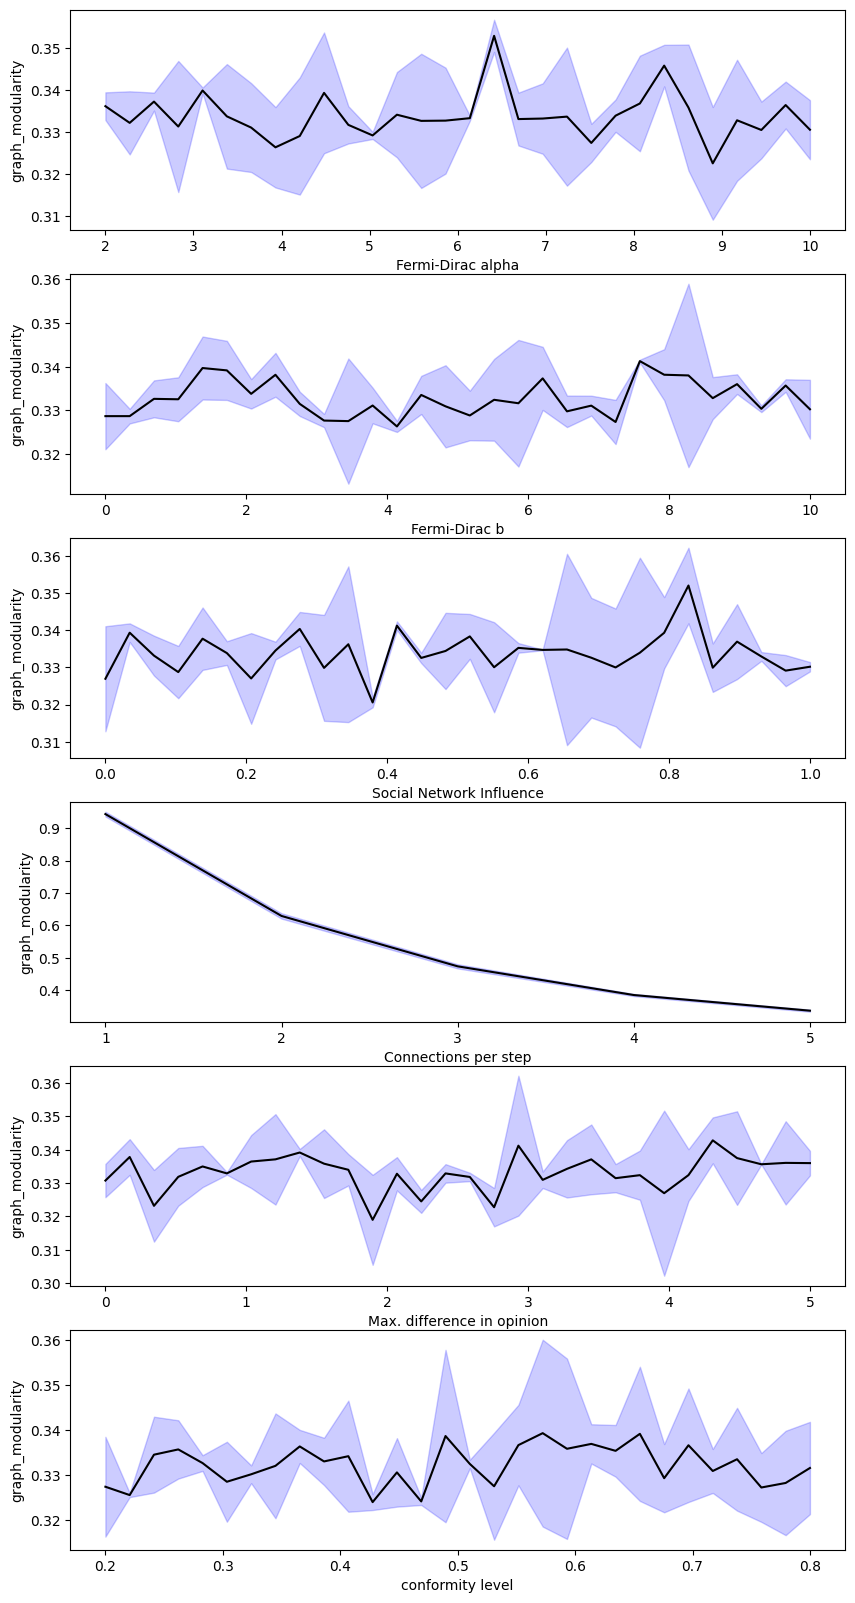

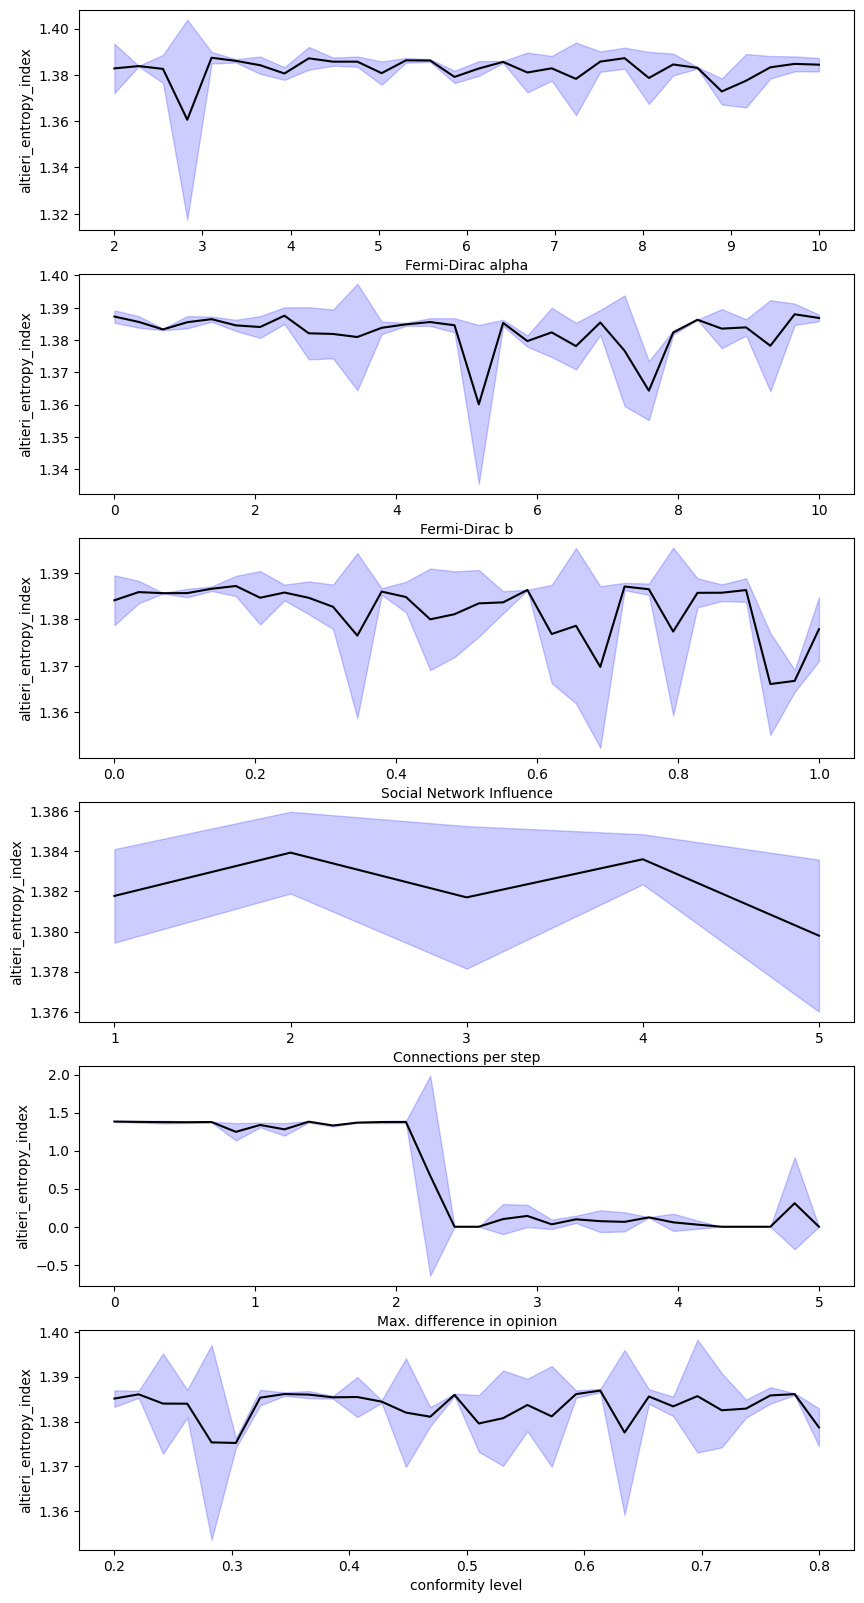

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')

    ax.fill_between(x,y-err,y+err,alpha=0.2,color='b')

    if var == 'fermi_alpha': xlabel = "Fermi-Dirac alpha"
    elif var == 'fermi_b': xlabel = "Fermi-Dirac b"
    elif var == "social_factor": xlabel = "Social Network Influence"
    elif var == "connections_per_step":
        xlabel = "Connections per step"
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    elif var == "opinion_max_diff": xlabel = "Max. difference in opinion"
    elif var == "conformity": xlabel = "conformity level"
    else: xlabel = var  # Default label if none of the above

    ax.set_xlabel(xlabel)
    ax.set_ylabel(param)


def plot_all_vars(data, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        data: dictionary of dataframes that holds all data
        param: the parameter to be plotted
    """
    # Filter out 'happiness_threshold' from the variable names
    vars_to_plot = [var for var in problem['names']]
    
    f, axs = plt.subplots(len(vars_to_plot), figsize=(10, 20))

    for i, var in enumerate(vars_to_plot):
        plot_param_var_conf(axs[i], data[var], var, param, i)

for param in ['graph_modularity', 'altieri_entropy_index']:
    print(f"Param: {param}")
    plot_all_vars(data, param)
    plt.savefig(f"{param}_OFAT3.png")

plt.show()


# Sobol SA

Sobol Sensitivity Analysis ([Sobol 2001](http://www.sciencedirect.com/science/article/pii/S0378475400002706), [Saltelli 2002](http://www.sciencedirect.com/science/article/pii/S0010465502002801), [Saltelli et al. 2010](http://www.sciencedirect.com/science/article/pii/S0010465509003087)) is a global SA method that determines the contribution of each input parameter or a combination of parameters and their interaction to the overall output variance. OFAT, while it is easier to implement (and certainly is less thought-intensive), has a couple of downsides.

1. OFAT requires a large amount of runs to get accurate results
2. OFAT cannot estimate interactions of combinations of inputs
3. OFAT can miss optimal settings of factors

Sobol can find higher order interactions, but still requires a large amount of runs.

### Getting the data

Before we can start analysing the model, we will have to sample our data. There are multiple methods for sampling included in SALib, but since we're using Sobol, we will use Saltelli sampling for this. 

The following code shows how you could collect data for the "wolf-sheep" model.

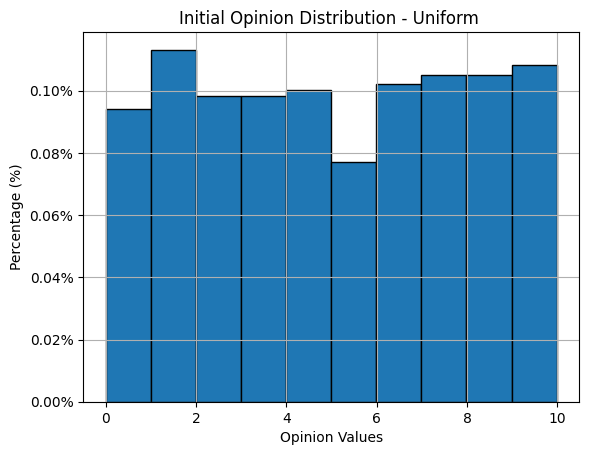

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 1000 random numbers from the uniform distribution (0, 10)
samples = np.random.uniform(0, 10, size=1000)

# Create the histogram with frequency as percentage
plt.hist(samples, bins=10, density=True, edgecolor='black')  # Use density=True for percentages

# Customize labels and title
plt.xlabel('Opinion Values')
plt.ylabel('Percentage (%)')
plt.title('Initial Opinion Distribution - Uniform ')

# Add grid for better readability
plt.grid(True)

# Format y-axis labels to display percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f"{y:.2f}%"))  # Format as percentages with 2 decimal places

plt.show()